# Investigating ANM for toy analysis

## Author: Alexandra Semposki

### Date last edited: 09 September 2024

We'll play with GPs here so that we do not have to mess up the true result notebook that we've been working with.

In [303]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from scipy.linalg import block_diag
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *
from pqcd_reworked import PQCD

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [304]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
print(data_xeft['density'].shape)
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

(600,)


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [305]:
# call training function to obtain desired data (for both data sets) (change now to test)
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
}

cutoff = 40
chiral_tr_data, pqcd_tr_data, training_data_full = gp_data(data_xeft_2, data_pqcd, cutoff, all_orders=False)

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 0.4, 600)[:-1]

(8,) (8,) (8,) (8, 8)
(8,) (8,) (8,) (8, 8)
(4,) (4,) (4,) (4, 4)
Cov shape: (12, 12)


In [306]:
# cut the pQCD data out for now
training_data_2 = {
    'dens': chiral_tr_data['dens'],#[::2],
    'mean': chiral_tr_data['mean'],#[::2],
    'std': chiral_tr_data['std'],#[::2],
    'cov': chiral_tr_data['cov']#[::2,::2],
}

# label pQCD data for later
# training_pqcd = {
#     'dens': training_data_full['dens'][7:],
#     'mean': training_data_full['mean'][7:],
#     'std': training_data_full['std'][7:],
#     'cov': training_data_full['cov'][7:,7:],
# }

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 0.40, 600)[:-1]

# cut this in half to obtain starting data
training_data = {
    'dens': training_data_2['dens'][::2],
    'mean': training_data_2['mean'][::2],
    'std': training_data_2['std'][::2],
    'cov': training_data_2['cov'][::2,::2]
}

# print results to check
print('Density: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

print('\nDensity: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

Density: 
 [0.11100167 0.14198664 0.17297162 0.20395659 0.23494157 0.26592654
 0.29691152 0.32789649]

Mean: 
 [0.05336242 0.07731449 0.10721393 0.14100458 0.1764836  0.21112742
 0.24240433 0.26779246]

Std dev: 
 [0.00631648 0.01071692 0.01637327 0.02352339 0.03233316 0.04305344
 0.05602828 0.0717272 ]

Density: 
 [0.11100167 0.17297162 0.23494157 0.29691152]

Mean: 
 [0.05336242 0.10721393 0.1764836  0.24240433]

Std dev: 
 [0.00631648 0.01637327 0.03233316 0.05602828]


Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [307]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)

errorbar_kwargs_2 = dict(
    capsize=3,
    ecolor="r",
    ls="none",
    marker="o",
    markerfacecolor="r",
    markeredgecolor="r",
    markersize=3
)

In [308]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

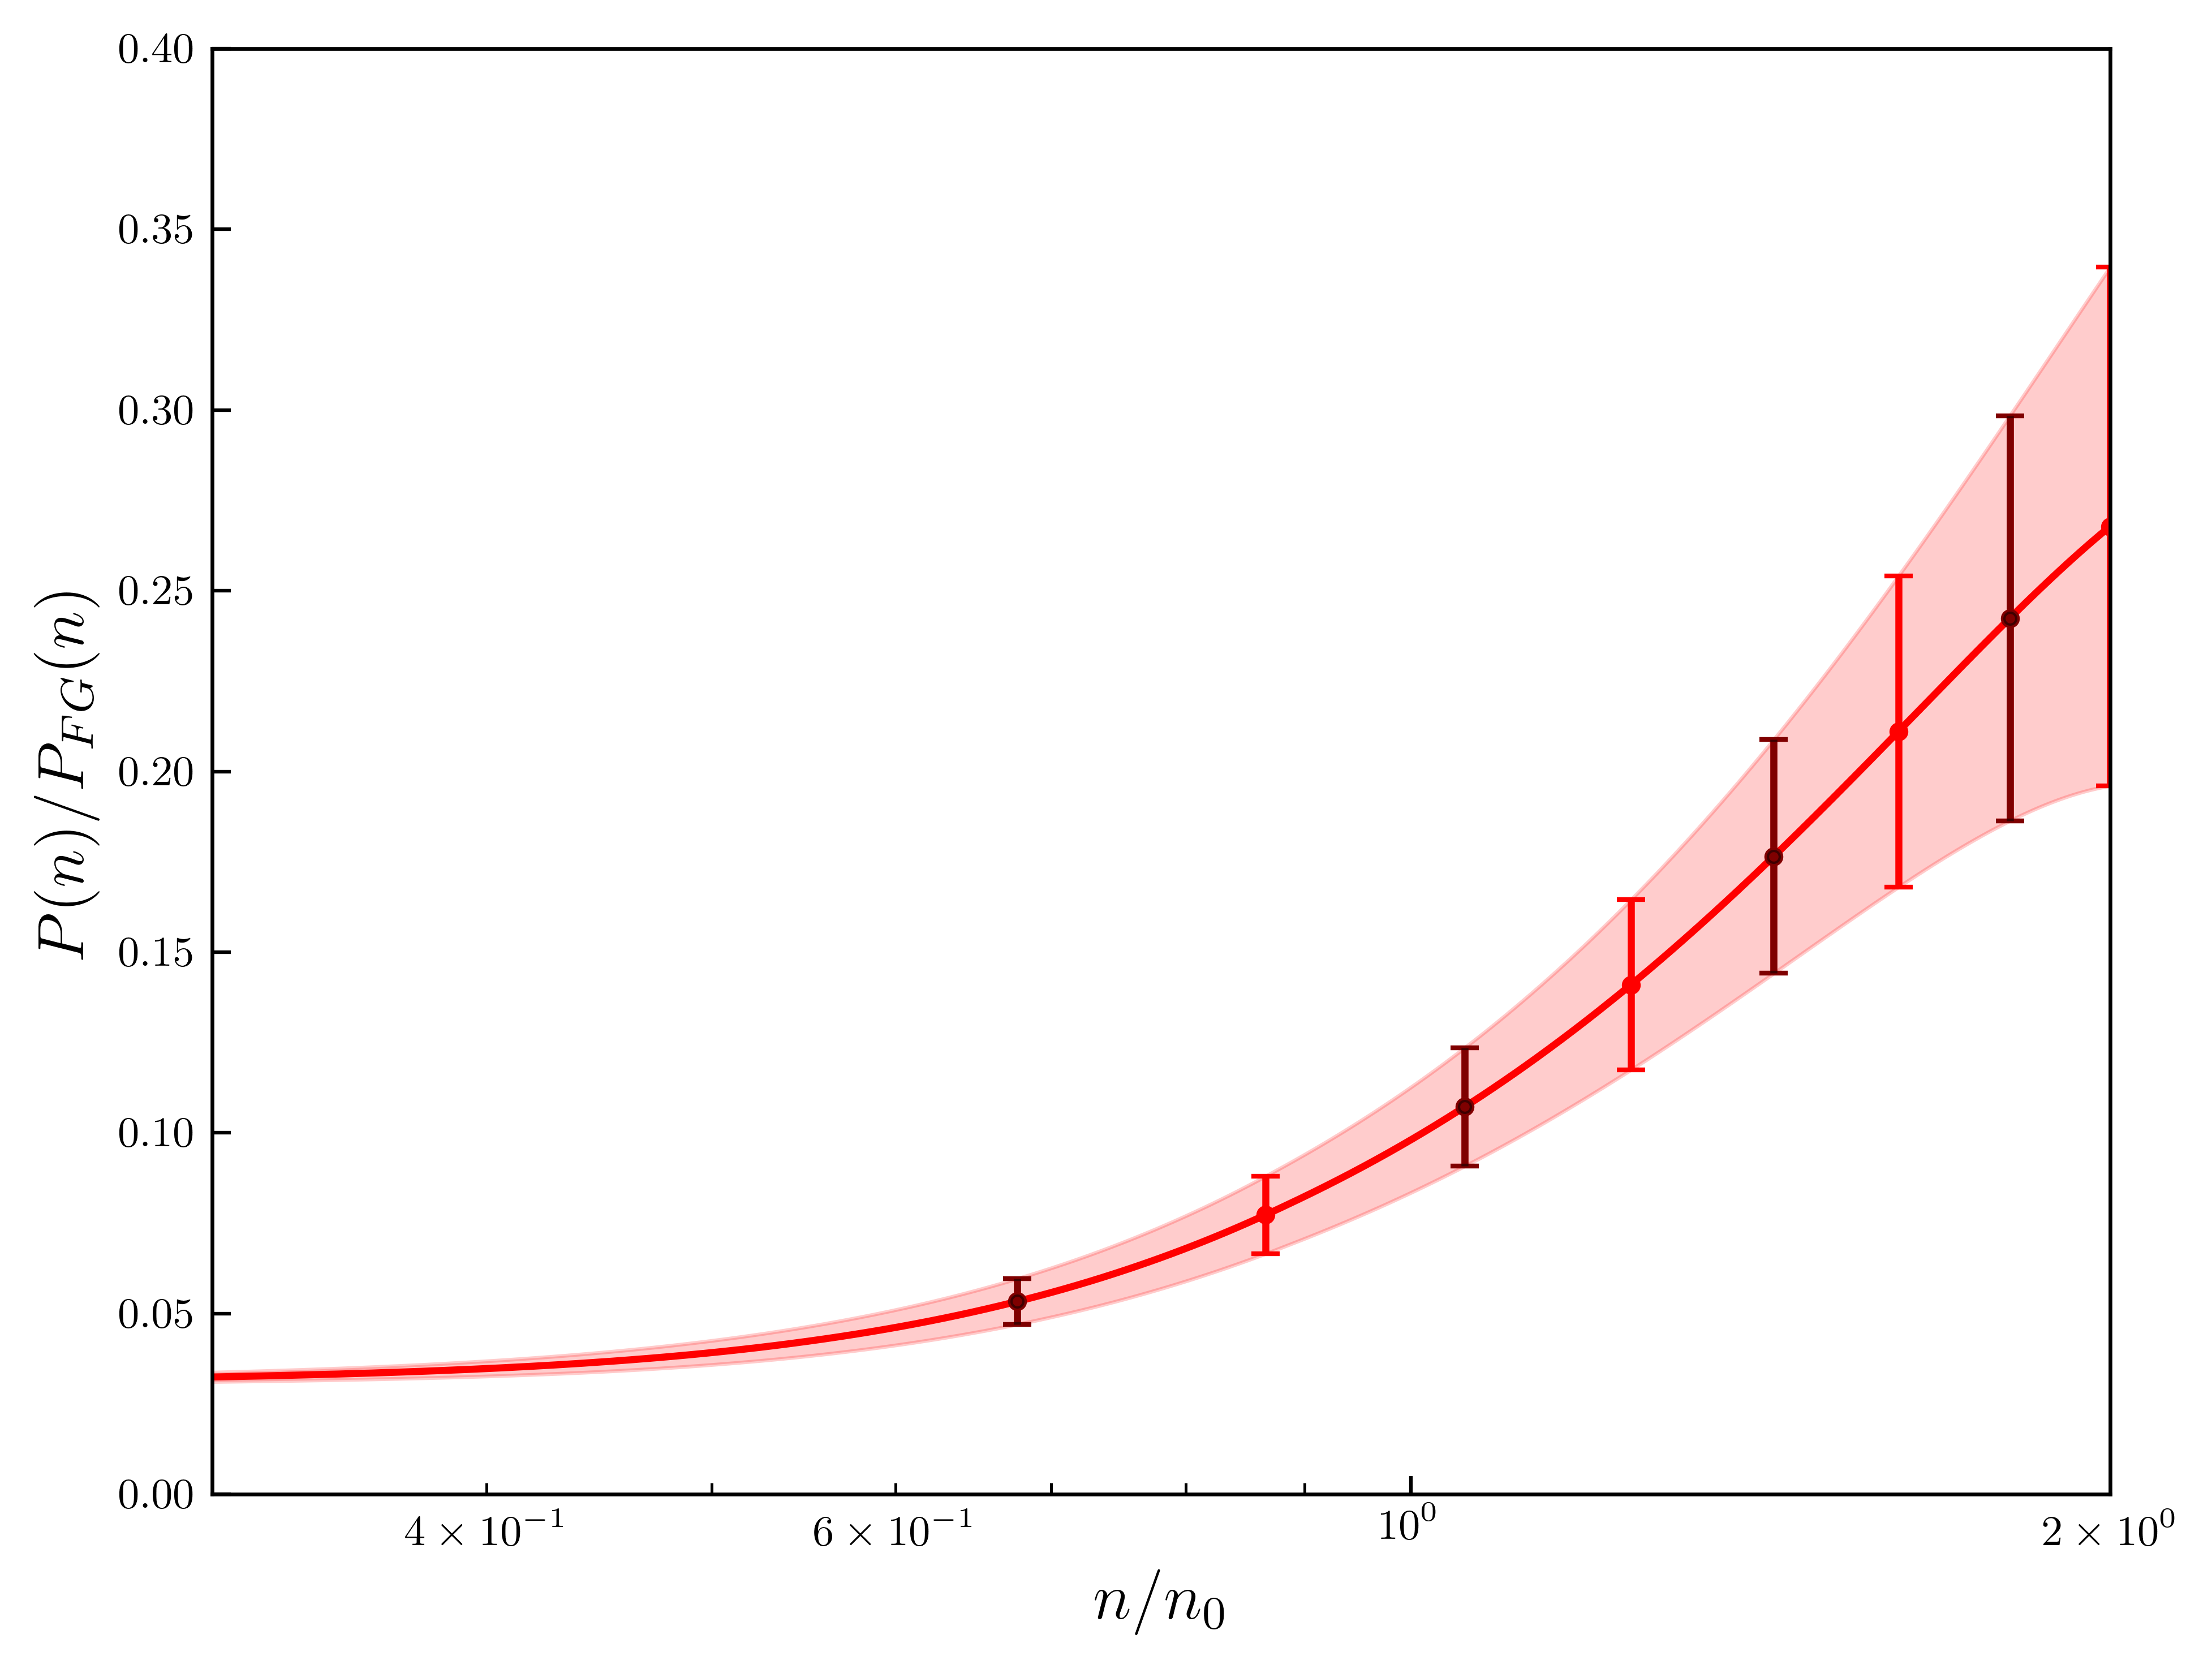

In [309]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(min(density_test)/n0, 2.0)
ax.set_ylim(0.0, 0.4)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, alpha=0.5)
#ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
#ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

We also need to compare the results of the work with the comparison of what happens when I use the same covariance matrix, and fix the lengthscale to reflect the two kernels I see when I work on the RBF kernel with two different covariance matrices.

In [310]:
# choose kernel
if cutoff == 40:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=1.1, length_scale_bounds=[0.6,1.2])
#     kernel = C(constant_value=1.0, constant_value_bounds='fixed') \
#     * RBF(length_scale=1.1, length_scale_bounds='fixed')
elif cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3, 1.0])
#     kernel = C(constant_value=1.0) \
#     * RBF(length_scale=0.9)

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

# create a small diagonal chicken nugget for the matrix (not needed without a prior?)
nugget = 1e-12*np.diag(np.ones(len(training_data['cov'])))
nugget_2 = 1e-08*np.diag(np.ones(len(training_data_2['cov'])))

In [311]:
# running plot of multiple hyperprior choices
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'] + nugget,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000,
)

gp.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='truncnorm_15')  

# running plot of multiple hyperprior choices
gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=1000
)

gp1.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='truncnorm_15')  

GaussianProcessRegressor2dNoise(alpha=array([[3.99078737e-05, 6.66558229e-05, 9.79546562e-05, 1.33093656e-04,
        1.70856288e-04, 2.10513236e-04, 2.51771076e-04, 2.94769424e-04],
       [6.66558229e-05, 1.14862303e-04, 1.73424139e-04, 2.41517622e-04,
        3.17092460e-04, 3.98778734e-04, 4.85869207e-04, 5.78408029e-04],
       [9.79546562e-05, 1.73424139e-04, 2.68094057e-04, 3.81377945e-04,...
        1.38179688e-03, 1.85360863e-03, 2.39622716e-03, 3.01077991e-03],
       [2.51771076e-04, 4.85869207e-04, 8.08571633e-04, 1.23313241e-03,
        1.76163147e-03, 2.39622716e-03, 3.13917820e-03, 3.99434944e-03],
       [2.94769424e-04, 5.78408029e-04, 9.76136952e-04, 1.50916170e-03,
        2.18486187e-03, 3.01077991e-03, 3.99434944e-03, 5.14480112e-03]]),
                                kernel=1.05**2 * RBF(length_scale=1.1),
                                n_restarts_optimizer=1000)

In [312]:
# print(training_data['cov'])
# print('\n')
# print(training_data_2['cov'])

print('Eigenvalues of the small covariance matrix: \n{}'.format(np.linalg.eig(training_data['cov'])[0]))

Eigenvalues of the small covariance matrix: 
[4.38751187e-03 1.01436531e-04 3.52923024e-06 1.06054464e-07]


We can print out the kernel hyperparameters ($\bar{c}$ and $\ell$) below, and see what we get using this kernel.

In [313]:
print(gp.kernel_)
print(gp1.kernel_)

0.928**2 * RBF(length_scale=1.06)
0.914**2 * RBF(length_scale=1.11)


In [314]:
# data peak from log likelihood
log_likelihood = []
log_likelihood_2 = []
ell = np.linspace(0.5, 2.0, 200)

In [315]:
#conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [316]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)

y_pred_0, y_stdv_0 = gp.predict(X, return_std=True)
_, y_cov_0 = gp.predict(X, return_cov=True)

y_pred_1, y_stdv_1 = gp1.predict(X, return_std=True)
_, y_cov_1 = gp1.predict(X, return_cov=True)

In [317]:
# compare the size of the error bars for both theories below at some select point (last point)
band_chiral = p_stdv_xeft[-1]
band_gp = y_stdv_1[497]  # 2n0
band_gp_2 = y_stdv_0[497]
#band_pqcd = p_stdv_pqcd[0]

# if cutoff == 20:
#     index_pqcd20 = np.where([density_test[i] <= 3.28 for i in range(len(density_test))])[0][-1]
#     band_gp_pqcd = y_stdv_1[index_pqcd20]
# elif cutoff == 40:
#     index_pqcd40 = np.where([density_test[i] <= 6.56 for i in range(len(density_test))])[0][-1]
#     band_gp_pqcd = y_stdv_1[index_pqcd40]
# print('here', band_gp_pqcd)
# print('here 2', band_pqcd)
print('Density at chosen point:', density_test[497], 'fm^-3')

# save for plot
diff_chiral_gp1 = round(((band_chiral - band_gp)/(band_chiral))*100, 2)
diff_chiral_gp2 = round(((band_chiral - band_gp_2)/(band_chiral))*100, 2)

# print out the differences
print('Difference between blue and chiral: ', diff_chiral_gp1)
print('Difference between purple and chiral: ', diff_chiral_gp2)

Density at chosen point: 0.34040066777963274 fm^-3
Difference between blue and chiral:  17.85
Difference between purple and chiral:  7.91


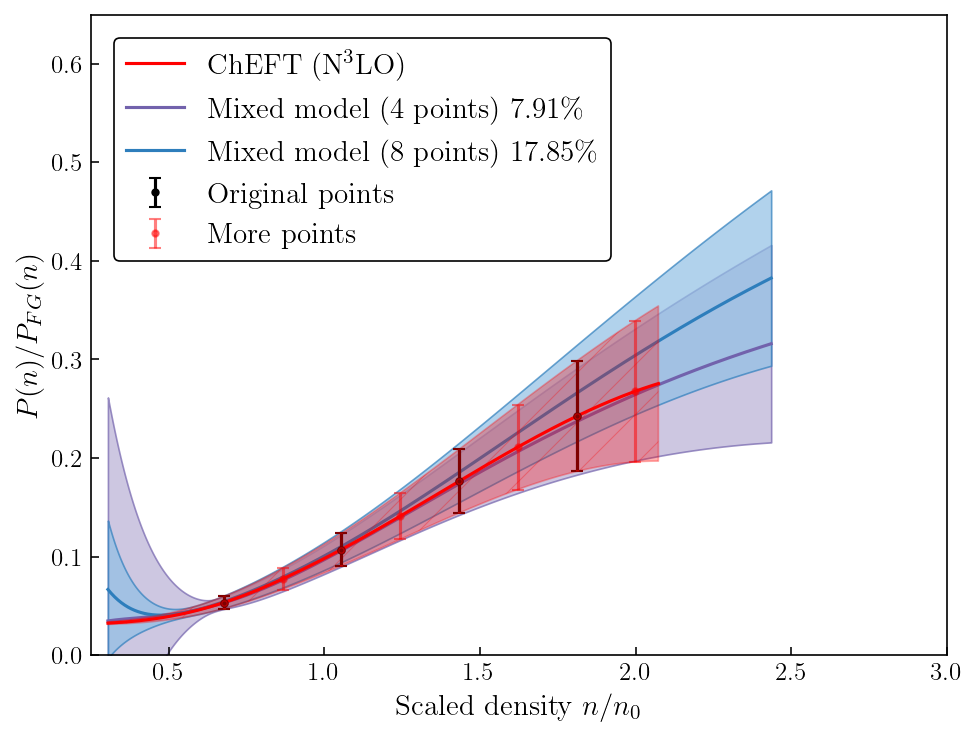

In [318]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.5)
#ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.3, \
                color=color_xeft, hatch='/')
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], color='k', \
            **errorbar_kwargs, label=r'Original points')
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], color='r', \
            **errorbar_kwargs_2, label=r'More points', alpha=0.5)

# ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO)')
# ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.3, color=color_pqcd, \
#                hatch='/')

# GP kernel choice results and uncertainty bands
ax.plot(density_test/n0, y_pred_0, c=colors[2], \
        label=r'Mixed model ({} points) {}\%'.format(len(training_data['cov']), diff_chiral_gp2), zorder=-1)
ax.fill_between(density_test/n0, y_pred_0-y_stdv_0, y_pred_0+y_stdv_0, facecolor=light_colors[2], \
                edgecolor=colors[2], alpha=0.7, zorder=-2)

ax.plot(density_test/n0, y_pred_1, c=colors[1], \
        label=r'Mixed model ({} points) {}\%'.format(len(training_data_2['cov']), diff_chiral_gp1), zorder=-1)
ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, facecolor=light_colors[1], \
                edgecolor=colors[1], alpha=0.7, zorder=-2)

plt.xlim(0.25, 3.0)
plt.ylim(0.0, 0.65)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.legend(fontsize=14, loc='upper left')
plt.show()

## Adding pQCD back in

Now, since we see not great results no matter what we do with the points above, we'll add pQCD back in and see if that helps our cause.

In [319]:
from scipy import linalg

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

# cut this in half to obtain starting data
training_data_chiral = {
    'dens': training_data['dens'][::2],
    'mean': training_data['mean'][::2],
    'std': training_data['std'][::2],
    'cov': training_data['cov'][::2,::2]
}

# stitch pQCD back onto the matrices
training_data_2 = {
    'dens': np.concatenate((chiral_tr_data['dens'][::2], pqcd_tr_data['dens'])),
    'mean': np.concatenate((chiral_tr_data['mean'][::2], pqcd_tr_data['mean'])),
    'std': np.concatenate((chiral_tr_data['std'][::2], pqcd_tr_data['std'])),
    'cov': linalg.block_diag(chiral_tr_data['cov'][::2,::2], pqcd_tr_data['cov'])
}

training_data = {
    'dens': np.concatenate((training_data_chiral['dens'], pqcd_tr_data['dens'])),
    'mean': np.concatenate((training_data_chiral['mean'], pqcd_tr_data['mean'])),
    'std': np.concatenate((training_data_chiral['std'], pqcd_tr_data['std'])),
    'cov': linalg.block_diag(training_data_chiral['cov'], pqcd_tr_data['cov'])
}

# print results to check
print('Density: \n', training_data_2['dens'])
print('\nMean: \n', training_data_2['mean'])
print('\nStd dev: \n', training_data_2['std'])

print('\nDensity: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

Density: 
 [ 0.11100167  0.17297162  0.23494157  0.29691152  6.5736227   9.30317195
 12.0327212  14.76227045]

Mean: 
 [0.05336242 0.10721393 0.1764836  0.24240433 1.09534974 1.0861765
 1.0805493  1.07662893]

Std dev: 
 [0.00631648 0.01637327 0.03233316 0.05602828 0.0192124  0.01519569
 0.0129697  0.01152593]

Density: 
 [ 0.11100167  0.23494157  6.5736227   9.30317195 12.0327212  14.76227045]

Mean: 
 [0.05336242 0.1764836  1.09534974 1.0861765  1.0805493  1.07662893]

Std dev: 
 [0.00631648 0.03233316 0.0192124  0.01519569 0.0129697  0.01152593]


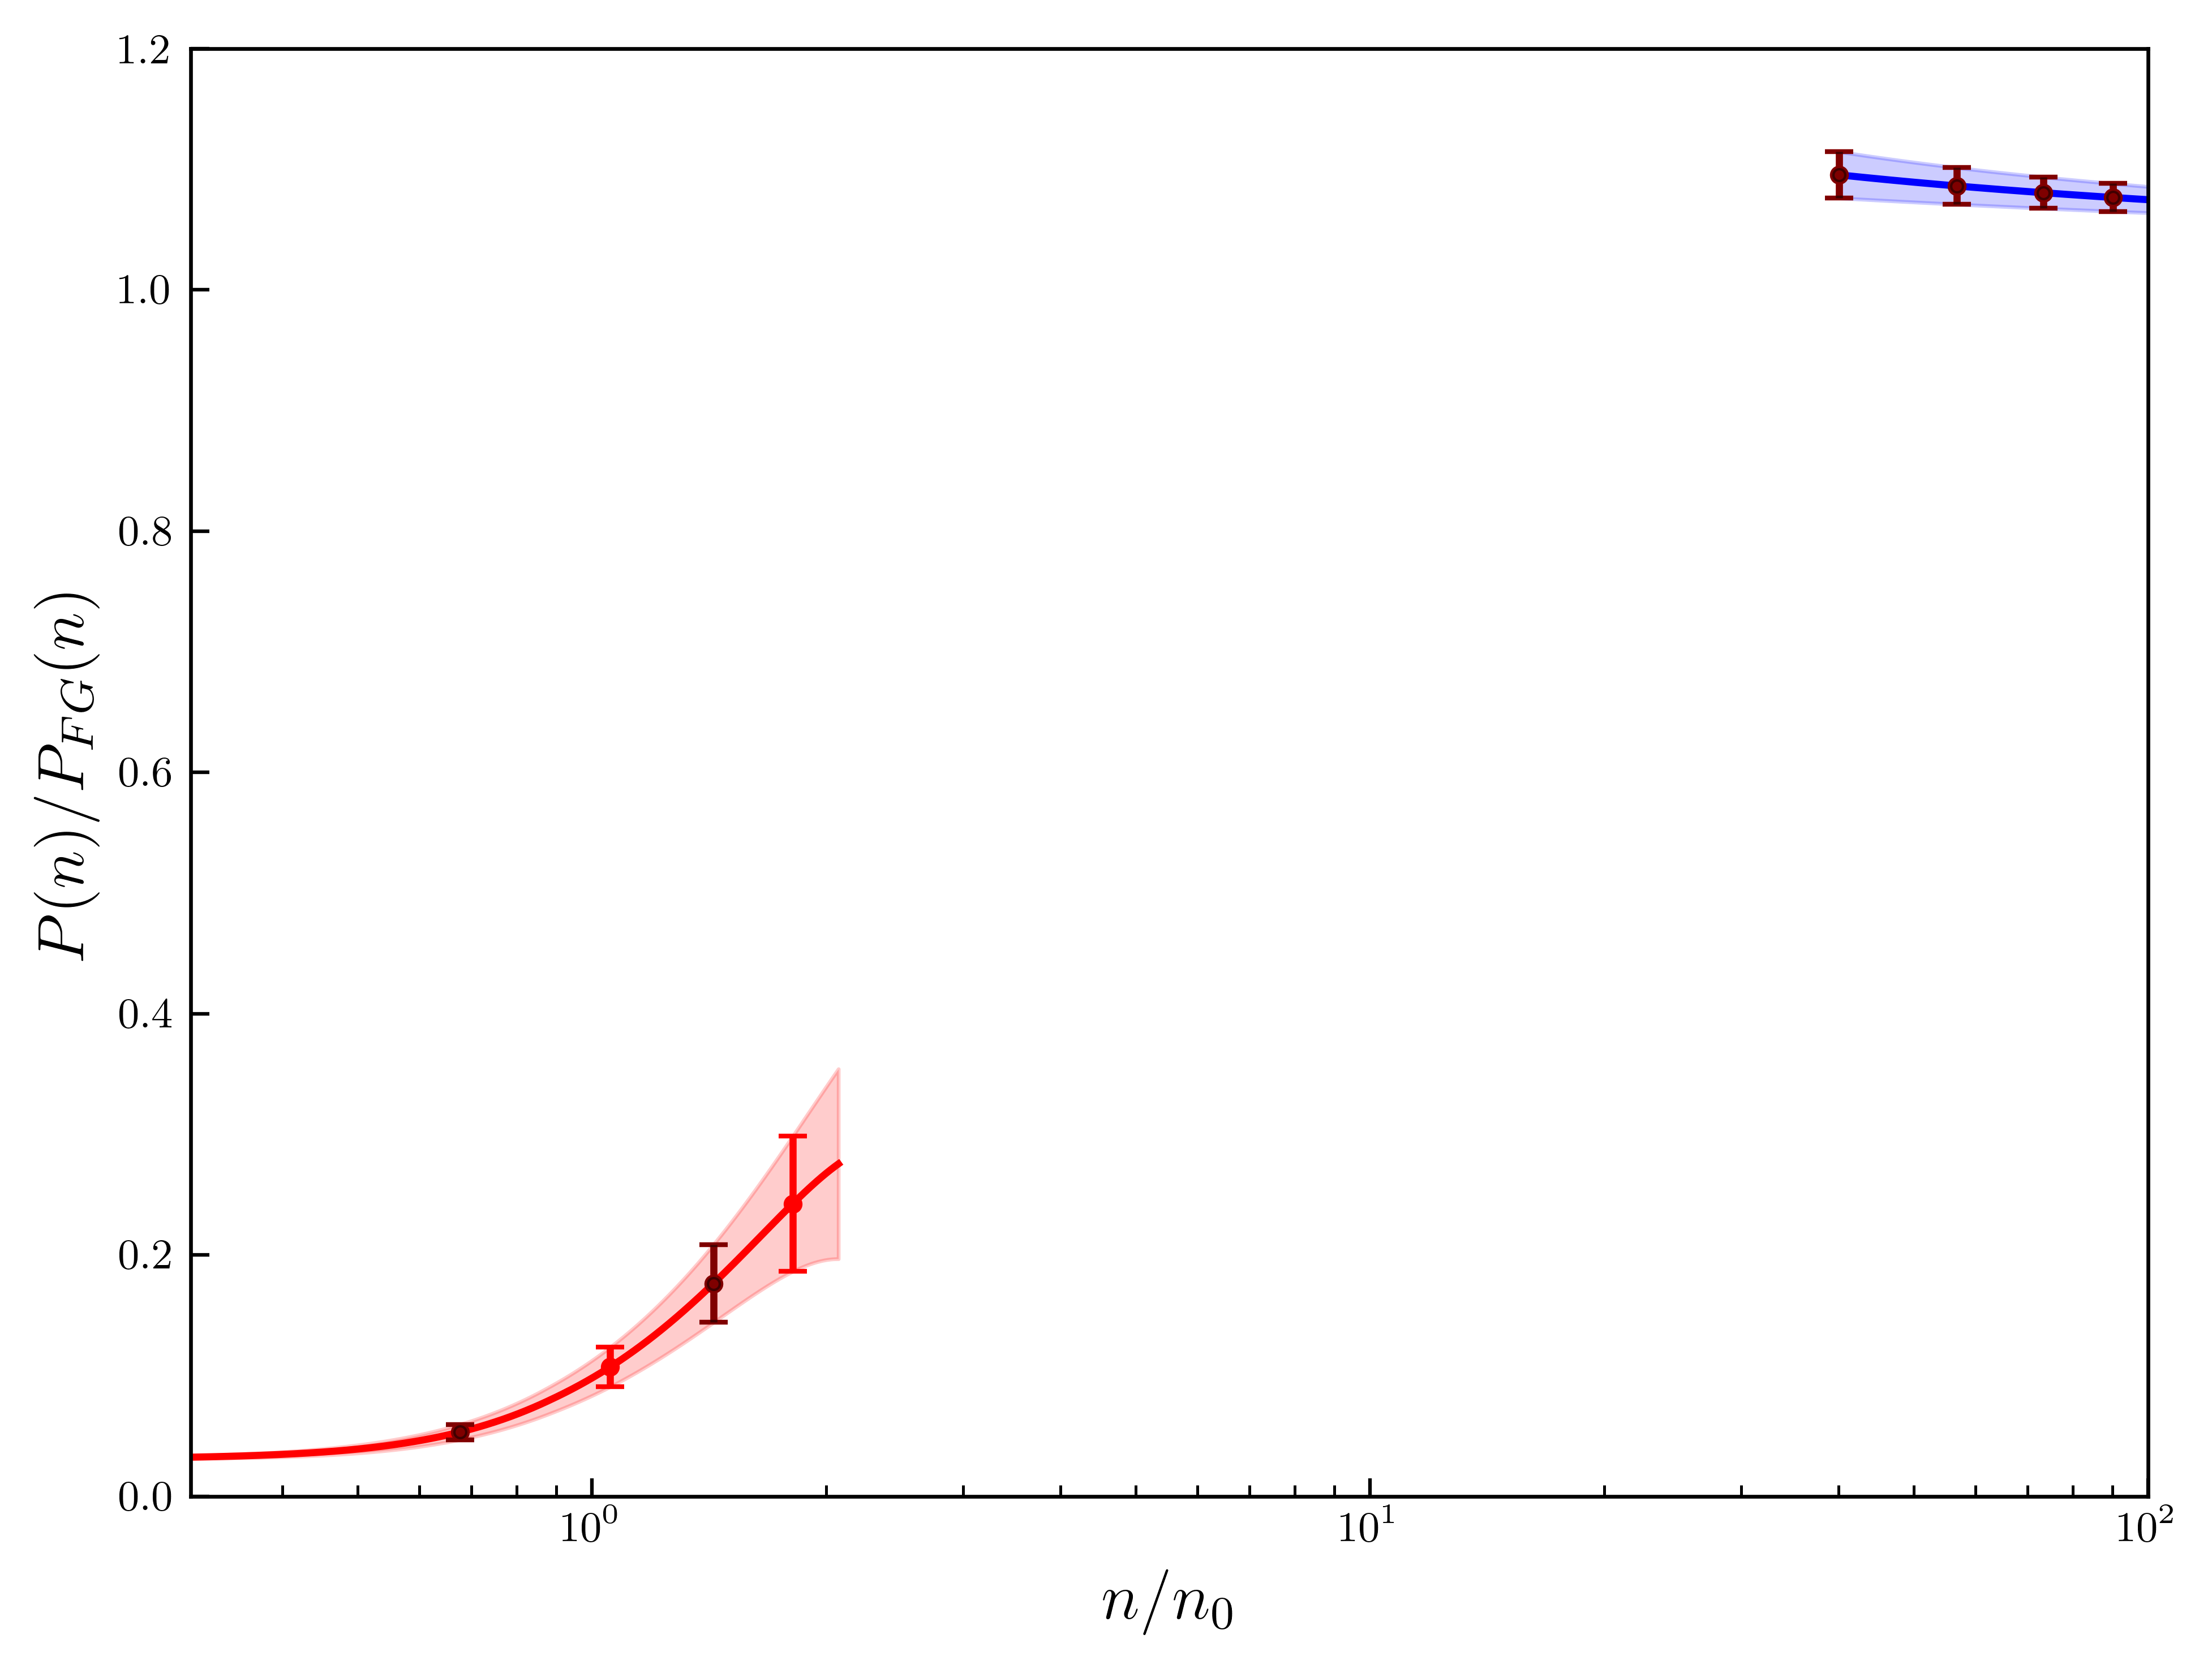

In [320]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(min(density_test)/n0, 100.0)
ax.set_ylim(0.0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs_2)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs, alpha=0.5)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
plt.show()

In [321]:
# choose kernel
if cutoff == 40:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=1.1, length_scale_bounds=[0.6,1.2])
#     kernel = C(constant_value=1.0, constant_value_bounds='fixed') \
#     * RBF(length_scale=1.1, length_scale_bounds='fixed')
elif cutoff == 20:
    kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
    RBF(length_scale=0.8, length_scale_bounds=[0.3, 1.0])
#     kernel = C(constant_value=1.0) \
#     * RBF(length_scale=0.9)

X_train = np.log(training_data['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data['mean'].reshape(-1,1)

X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train_2 = training_data_2['mean'].reshape(-1,1)

# create a small diagonal chicken nugget for the matrix (not needed without a prior?)
nugget = 1e-12*np.diag(np.ones(len(training_data['cov'])))
nugget_2 = 1e-08*np.diag(np.ones(len(training_data_2['cov'])))

# running plot of multiple hyperprior choices
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data['cov'], #+ nugget,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000,
)

gp.fit(X_train, y_train, priors=True, cutoff=cutoff, prior_choice='truncnorm_15')  

# running plot of multiple hyperprior choices
gp1 = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget_2,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000
)

gp1.fit(X_train_2, y_train_2, priors=True, cutoff=cutoff, prior_choice='truncnorm_15')  

print(gp.kernel_)
print(gp1.kernel_)

0.928**2 * RBF(length_scale=1.09)
0.876**2 * RBF(length_scale=1.18)


In [322]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)

y_pred_0, y_stdv_0 = gp.predict(X, return_std=True)
_, y_cov_0 = gp.predict(X, return_cov=True)

y_pred_1, y_stdv_1 = gp1.predict(X, return_std=True)
_, y_cov_1 = gp1.predict(X, return_cov=True)

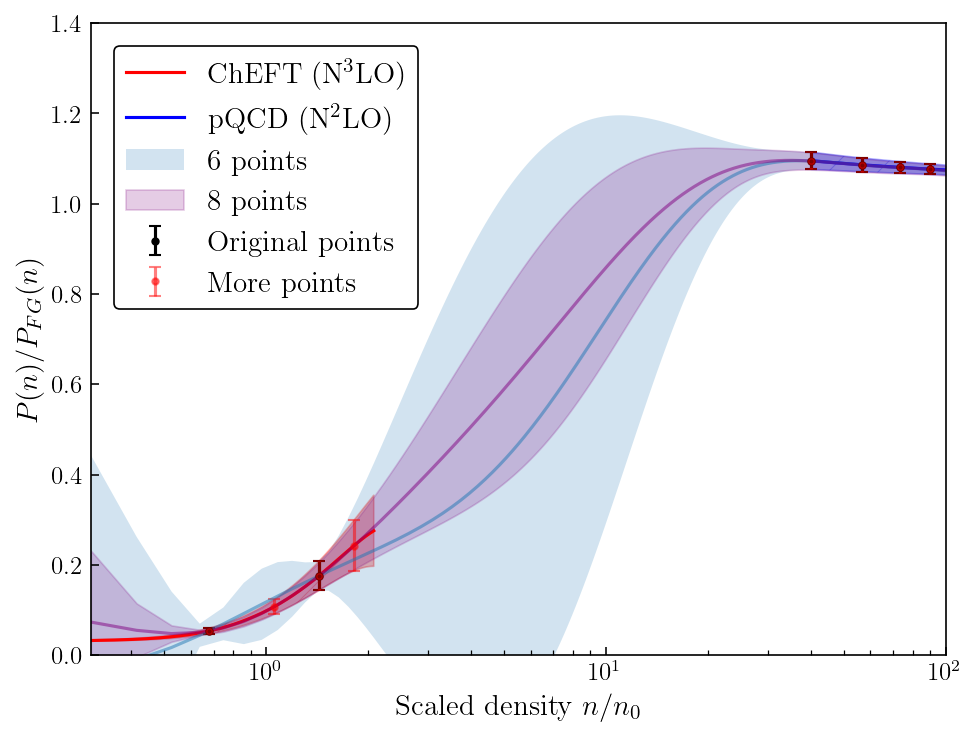

In [323]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.4)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N$^3$LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.3, \
                color=color_xeft, hatch='/')
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], color='k', \
            **errorbar_kwargs, label=r'Original points')
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], color='r', \
            **errorbar_kwargs_2, label=r'More points', alpha=0.5)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N$^2$LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.3, color=color_pqcd, \
               hatch='/')

# GP kernel choice results and uncertainty bands
ax.plot(density_test/n0, y_pred_0, alpha=0.5)
ax.plot(density_test/n0, y_pred_1, alpha=0.5, color='purple')
ax.fill_between(density_test/n0, y_pred_0-y_stdv_0, y_pred_0+y_stdv_0, \
                label=r'{} points'.format(len(training_data['dens'])), \
                alpha=0.2)
ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, \
                label=r'{} points'.format(len(training_data_2['dens'])), \
                color='purple', alpha=0.2)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(r'Scaled density $n/n_{0}$', fontsize=14)
plt.ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
plt.legend(fontsize=14, loc='upper left')
plt.show()

In [324]:
# correlation coefficients with pQCD
# check out the covariance matrix
print(y_cov_0.shape)
print(y_cov_1.shape)
index_2n0 = np.where([density_test[i] >= 0.34 for i in range(len(density_test))])[0][0]
print([index_2n0])
index_40n0 = np.where([density_test[i] >= 6.56 for i in range(len(density_test))])[0][0]

# covariances
y_var0_2n0 = y_cov_0[index_2n0, index_2n0]
y_var0_40n0 = y_cov_0[index_40n0, index_40n0]
y_cross0_2n0_40n0 = y_cov_0[index_2n0, index_40n0]

# covariances between 5n0 and 40n0 here
y_var1_2n0 = y_cov_1[index_2n0, index_2n0]
y_var1_40n0 = y_cov_1[index_40n0, index_40n0]
y_cross1_2n0_40n0 = y_cov_1[index_2n0, index_40n0]

# correlation coefficients
corr_coeff = y_cross0_2n0_40n0 / (np.sqrt(y_var0_2n0) * np.sqrt(y_var0_40n0))
corr_coeff_2 = y_cross1_2n0_40n0 / (np.sqrt(y_var1_2n0) * np.sqrt(y_var1_40n0))
print('Correlation coefficient, blue curve: ', corr_coeff)
print('Correlation coefficient, purple curve: ', corr_coeff_2)

(899, 899)
(899, 899)
[16]
Correlation coefficient, blue curve:  0.009110803529415032
Correlation coefficient, purple curve:  0.011309582420513593


There is still a high correlation, when adding more points in. Not when we only have a few, however. But then at the moment that one looks terrible. 

The question now is, is all of this because of the shape of the covariance structure in ANM? I don't see another plausible explanation at the moment.